## Basics

In [1]:
from primitives import Parameters
p = Parameters()
import matplotlib.pyplot as plt
import numpy as np

In [6]:
import ipywidgets as widgets
from IPython.display import display

# Create a slider widget
slider = widgets.IntSlider(value=10, min=0, max=100, step=1)
display(slider)

IntSlider(value=10)

In [2]:
from ContinuousContract import ContinuousContract
cc=ContinuousContract(p)
(cc_J,cc_W,cc_Wstar,cc_Jpi,cc_pc)=cc.J(0)

(100,)


In [3]:
#%%timeit
from Multiworker_Contract_sep_direct import MultiworkerContract
K=2 #number of tenure levels
mwc=MultiworkerContract(p,cc.js)
(mwc_s_dir_J,mwc_s_dir_W,mwc_s_dir_Wstar,mwc_s_dir_sep)=mwc.J()

Ji shape (7, 4, 4, 100)
W1i shape (7, 4, 4, 100, 2)


c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  self.rsqr[iz, in0, in1] = res2.fun / np.power(J1[iz, in0, in1, :],2).mean()
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:21: RuntimeWarning: divide by zero encountered in log
  g3     = 2 * ( Ri * np.log( Xi_arg ) * Xi_pow * gamma[1] ).mean() #Derivative wrt gamma[2]
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:21: RuntimeWarning: invalid value encountered in multiply
  g3     = 2 * ( Ri * np.log( Xi_arg ) * Xi_pow * gamma[1] ).mean() #Derivative wrt gamma[2]
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:12: RuntimeWarning: divide by zero encountered in power
  Xi_pow = np.power( Xi_arg , gamma[2])
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:21: RuntimeWarning: divide by zero

Errors: nan 3.5264384857806705 nan 0.7407048963831014 1
Errors: nan 3.5264384857806705 nan 0.7407048963831014 1
EJinv 580.79206521345
EJderiv -7.8234865818979875
EJinv diff: 10.584520409290842
EJinv diff 1 sen: 0.27793786975538176
sep borders 0.0 1.0
EJinv 1027.5460269129644
EJderiv -10.101938495520576
EJinv diff: 17.344473408112318
EJinv diff 1 sen: 0.3336356650710491
sep borders 0.0 1.0
EJinv 1270.6927606404718
EJderiv -199.5859341348347
EJinv diff: 21.892868860357435
EJinv diff 1 sen: 0.23910422959665995
sep borders 0.0 1.0
EJinv 1397.5675706066245
EJderiv -201.9807147282516
EJinv diff: 12.987210908844483
EJinv diff 1 sen: 0.24251602465055327
sep borders 0.0 1.0
EJinv 1444.130608538877
EJderiv -202.77399275146738
EJinv diff: 188.46507153022776
EJinv diff 1 sen: 0.4373074600604246
sep borders 0.0 1.0
EJinv 1444.9647996994984
EJderiv -201.86051124923898
EJinv diff: 12.892499078375312
EJinv diff 1 sen: 0.24381052893570565
sep borders 0.0 1.0
EJinv 1420.1736991496587
EJderiv -199.561570

c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:169: RuntimeWarning: invalid value encountered in divide
  W = W / W.sum()


sep borders 0.0 1.0
EJinv 1237.5732407662467
EJderiv -183.62905807783028
EJinv diff: 11.341656990821521
EJinv diff 1 sen: 0.20981343330953825
sep borders 0.0 1.0
EJinv 1188.6300488315906
EJderiv -179.1593726452224
EJinv diff: 14.033840811693736
EJinv diff 1 sen: 1.0901048832193407
sep borders 0.0 1.0
EJinv 1140.923867007843
EJderiv -174.7360768370726
EJinv diff: 46.723050492007125
EJinv diff 1 sen: 0.28543800973156597
sep borders 0.0 1.0
EJinv 1094.8075621014282
EJderiv -170.40502596297753
EJinv diff: 8.942253992378367
EJinv diff 1 sen: 0.2797251019244443
sep borders 0.0 1.0
EJinv 1050.434725988964
EJderiv -166.19099279144015
EJinv diff: 8.918253063922853
EJinv diff 1 sen: 0.22349902396129445
sep borders 0.0 1.0
EJinv 1007.8451848699995
EJderiv -162.10545399992856
EJinv diff: 8.915556459616822
EJinv diff 1 sen: 0.24412117522993754
sep borders 0.0 1.0
EJinv 967.0152282506076
EJderiv -158.15247839007617
EJinv diff: 8.939961179994581
EJinv diff 1 sen: 0.21660894771496486
sep borders 0.0 1

In [4]:
#%%timeit
from Multiworker_Contract_sep import MultiworkerContract
K=2 #number of tenure levels
mwc=MultiworkerContract(p,cc.js)
(mwc_s_J,mwc_s_W,mwc_s_Wstar,mwc_s_sep)=mwc.J()
#(mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n1)=mwc.J(0,mwc_J,mwc_W)

Ji shape (7, 4, 4, 100)
W1i shape (7, 4, 4, 100, 2)


c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  self.rsqr[iz, in0, in1] = res2.fun / np.power(J1[iz, in0, in1, :],2).mean()
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:21: RuntimeWarning: divide by zero encountered in log
  g3     = 2 * ( Ri * np.log( Xi_arg ) * Xi_pow * gamma[1] ).mean() #Derivative wrt gamma[2]
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:21: RuntimeWarning: invalid value encountered in multiply
  g3     = 2 * ( Ri * np.log( Xi_arg ) * Xi_pow * gamma[1] ).mean() #Derivative wrt gamma[2]
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:12: RuntimeWarning: divide by zero encountered in power
  Xi_pow = np.power( Xi_arg , gamma[2])
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:21: RuntimeWarning: divide by zero

Errors: nan 3.5264384857806705 nan 0.7407048963831014 1
Errors: nan 3.5264384857806705 nan 0.7407048963831014 1
EJinv 580.79206521345
EJderiv -7.8234865818979875
EJinv diff: 10.584520409290842
EJinv diff 1 sen: 0.27793786975538176
sep borders 0.0 1.0
EJinv 1027.5460269129644
EJderiv -10.101938495520576
EJinv diff: 17.34447340811193
EJinv diff 1 sen: 0.3336356650710491
sep borders 0.0 1.0
EJinv 1295.8794524957832
EJderiv -199.93847919217293
EJinv diff: 5.456962406792019
EJinv diff 1 sen: 0.23910422959665995
sep borders 0.0 1.0
EJinv 639.217591237759
EJderiv -188.90392511454135
EJinv diff: 12.21120046138785
EJinv diff 1 sen: 0.24251602465055327
sep borders 0.0 1.0
EJinv 254.5279287700534
EJderiv -1.200514437161745
EJinv diff: 90.76463931431853
EJinv diff 1 sen: 0.4373074600604246
sep borders 0.0 1.0
EJinv 31.93356508523732
EJderiv 1.1739629887973877
EJinv diff: 15.338070128924665
EJinv diff 1 sen: 0.24381052893570565
sep borders 0.0 1.0
EJinv -94.398924663743
EJderiv 2.805522500357717
EJ

c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:169: RuntimeWarning: invalid value encountered in divide
  W = W / W.sum()


sep borders 0.0 1.0
EJinv -221.3749897982853
EJderiv 6.8366533982738105
EJinv diff: 18.34200000610766
EJinv diff 1 sen: 1.0901048832193407
sep borders 0.0 1.0
EJinv -217.23840760949145
EJderiv 7.326987836512104
EJinv diff: 24.265811810229103
EJinv diff 1 sen: 0.28543800973156597
sep borders 0.0 1.0
EJinv -211.37433501498825
EJderiv 7.7734984062271
EJinv diff: 22.175962754194906
EJinv diff 1 sen: 0.2797251019244443
sep borders 0.0 1.0
EJinv -204.73970404029293
EJderiv 8.1849317389197
EJinv diff: 16.39033527553257
EJinv diff 1 sen: 0.22349902396129445
sep borders 0.0 1.0
EJinv -197.87383741153118
EJderiv 8.566940003965602
EJinv diff: 14.859033506147009
EJinv diff 1 sen: 0.24412117522993754
sep borders 0.0 1.0
EJinv -191.07253600016523
EJderiv 8.923294583368882
EJinv diff: 28.650866950419587
EJinv diff 1 sen: 0.21660894771496486
sep borders 0.0 1.0
EJinv -184.4903445556637
EJderiv 9.256600003693574
EJinv diff: 14.164595413566223
EJinv diff 1 sen: 0.219518716175908
sep borders 0.0 1.0
EJin

In [5]:
#%%timeit
from Multiworker_Contract import MultiworkerContract
K=2 #number of tenure levels
mwc=MultiworkerContract(p,cc.js)
(mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n1)=mwc.J()
#(mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n1)=mwc.J(0,mwc_J,mwc_W)

Ji shape (7, 4, 4, 100)
W1i shape (7, 4, 4, 100, 2)


c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  self.rsqr[iz, in0, in1] = res2.fun / np.power(J1[iz, in0, in1, :],2).mean()
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:21: RuntimeWarning: divide by zero encountered in log
  g3     = 2 * ( Ri * np.log( Xi_arg ) * Xi_pow * gamma[1] ).mean() #Derivative wrt gamma[2]
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:21: RuntimeWarning: invalid value encountered in multiply
  g3     = 2 * ( Ri * np.log( Xi_arg ) * Xi_pow * gamma[1] ).mean() #Derivative wrt gamma[2]
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:12: RuntimeWarning: divide by zero encountered in power
  Xi_pow = np.power( Xi_arg , gamma[2])
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:21: RuntimeWarning: divide by zero

Errors: nan 3.5129010391766817 nan 0.705348962392721 1
Errors: nan 3.5129010391766817 nan 0.705348962392721 1
EJinv 580.79206521345
EJderiv -7.823486581898034
EJinv diff: 10.584520409290844
EJinv diff 1 sen: 0.27793786975538176
EJinv 1027.5460269129642
EJderiv -10.101938495523793
EJinv diff: 17.34447340811092
EJinv diff 1 sen: 0.3336356650710491
EJinv 1267.1708743367512
EJderiv -10.767428409221763
EJinv diff: 29.17831794112126
EJinv diff 1 sen: 0.23910422959665995
EJinv 1384.5821569321727
EJderiv -10.789784029478618
EJinv diff: 23.38178058151617
EJinv diff 1 sen: 0.24251602465055327
EJinv 1430.1265270346446
EJderiv -10.517044647885463
EJinv diff: 29.155541630786388
EJinv diff 1 sen: 0.4373074600604246
EJinv 1433.7793926105558
EJderiv -10.08952229642592
EJinv diff: 27.167160652284707
EJinv diff 1 sen: 0.24381052893570565
EJinv 1413.3679393858224
EJderiv -9.584292812751759
EJinv diff: 26.356570219261204
EJinv diff 1 sen: 6.377419156948708
EJinv 1379.4988406402065
EJderiv -9.0381125341380

c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:169: RuntimeWarning: invalid value encountered in divide
  W = W / W.sum()


Errors: nan 0.21388093493978366 nan 0.003211392867302163 1
EJinv 1294.0194521824587
EJderiv -7.8964622117866625
EJinv diff: 32.134755719210155
EJinv diff 1 sen: 0.22183068057001562
EJinv 1248.3335702515803
EJderiv -7.32047372307221
EJinv diff: 28.760078487616006
EJinv diff 1 sen: 0.20981343330953825
EJinv 1202.6920795675999
EJderiv -6.748020644029652
EJinv diff: 29.23191933268232
EJinv diff 1 sen: 1.0901048832193407
EJinv 1157.8239481558608
EJderiv -6.181889638441338
EJinv diff: 28.71130345919597
EJinv diff 1 sen: 0.28543800973156597
EJinv 1114.130935659777
EJderiv -5.623778846910742
EJinv diff: 53.45647362922153
EJinv diff 1 sen: 0.2797251019244443
EJinv 1071.819732688922
EJderiv -5.0747010860644055
EJinv diff: 41.43338651749017
EJinv diff 1 sen: 0.22349902396129445
EJinv 1030.9810640084722
EJderiv -4.535236941415027
EJinv diff: 24.155308856656184
EJinv diff 1 sen: 0.24412117522993754
EJinv 991.6370645844736
EJderiv -4.005659033389264
EJinv diff: 26.32937976721426
EJinv diff 1 sen: 0.

# Plots

In [7]:
import matplotlib.pyplot as plt
import os
# Create a directory to save plots
output_dir = 'Plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

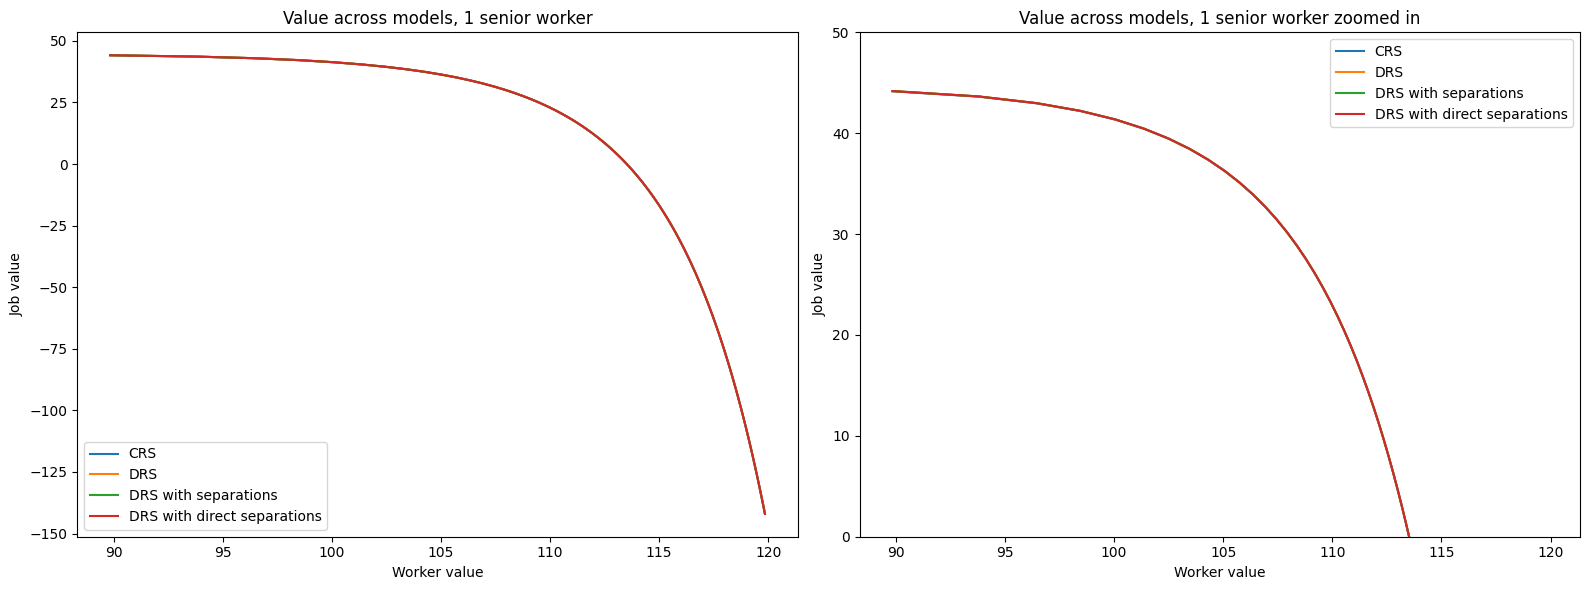

In [8]:
# Create a figure with a specific size
plt.figure(figsize=(16, 6))  # Width=16 inches, Height=6 inches

# First subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
# Plot the data
plt.plot(cc_W[p.z_0-1, :], cc_J[p.z_0-1, :], label='CRS')
plt.plot(mwc_W[p.z_0-1, 0, 1, :, 1], mwc_J[p.z_0-1, 0, 1, :], label='DRS')
#plt.plot(mwc_inter_W[p.z_0-1, 0, 1, :, 1], mwc_inter_J[p.z_0-1, 0, 1, :], label='DRS with extrapolation')
plt.plot(mwc_s_W[p.z_0-1, 0, 1, :, 1], mwc_s_J[p.z_0-1, 0, 1, :], label='DRS with separations')
plt.plot(mwc_s_dir_W[p.z_0-1, 0, 1, :, 1], mwc_s_dir_J[p.z_0-1, 0, 1, :], label='DRS with direct separations')
# Add titles and labels
plt.title('Value across models, 1 senior worker')
plt.xlabel('Worker value')
plt.ylabel('Job value')

plt.legend()

#plt.ylim([0, 200])

# Second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(cc_W[p.z_0-1, :], cc_J[p.z_0-1, :], label='CRS')
plt.plot(mwc_W[p.z_0-1, 0, 1, :, 1], mwc_J[p.z_0-1, 0, 1, :], label='DRS')
#plt.plot(mwc_inter_W[p.z_0-1, 0, 1, :, 1], mwc_inter_J[p.z_0-1, 0, 1, :], label='DRS with extrapolation')
plt.plot(mwc_s_W[p.z_0-1, 0, 1, :, 1], mwc_s_J[p.z_0-1, 0, 1, :], label='DRS with separations')
plt.plot(mwc_s_dir_W[p.z_0-1, 0, 1, :, 1], mwc_s_dir_J[p.z_0-1, 0, 1, :], label='DRS with direct separations')

# Add titles and labels
plt.title('Value across models, 1 senior worker zoomed in')
plt.xlabel('Worker value')
plt.ylabel('Job value')

plt.ylim([0, 50])

plt.legend()


# Adjust layout to prevent overlap
plt.tight_layout()

# Add legend
plt.legend()

# Save the plot to a file in the specified directory
save=0
if save==1:
    plt.savefig(os.path.join(output_dir,'Value CRS vs DRS.png'), bbox_inches='tight')  # Save as PNG


# Optionally set x and y limits
#plt.xlim([-10, 40])
#plt.ylim([0, 200])
# Save the plot to a file
save=0
if save==1:
    plt.savefig(os.path.join(output_dir,'Value CRS vs DRS zoom.png'), bbox_inches='tight')  # Save as PNG

# Show the plot (optional)
plt.show()

Text(0, 0.5, 'Value change over time')

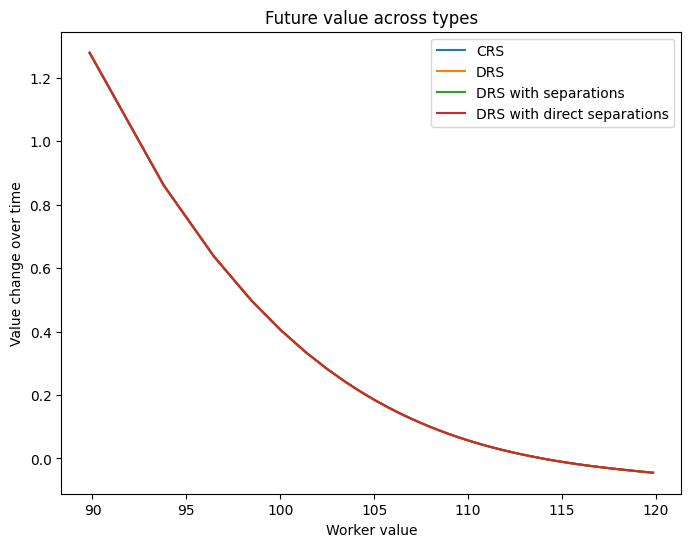

In [9]:
plt.figure(figsize=(8, 6))  # Width=16 inches, Height=12 inches

# Plot the data
plt.plot(cc_W[p.z_0-1, :], cc_Wstar[p.z_0-1, :]-cc_W[p.z_0-1, :], label='CRS')
plt.plot(mwc_W[p.z_0-1, 0, 1,:, 1], mwc_Wstar[p.z_0-1, 0, 1, :]-mwc_W[p.z_0-1, 0, 1,:, 1], label='DRS')
plt.plot(mwc_s_W[p.z_0-1, 0, 1,:, 1], mwc_s_Wstar[p.z_0-1, 0, 1, :]-mwc_s_W[p.z_0-1, 0, 1,:, 1], label='DRS with separations')
plt.plot(mwc_s_dir_W[p.z_0-1, 0, 1,:, 1], mwc_s_dir_Wstar[p.z_0-1, 0, 1, :]-mwc_s_dir_W[p.z_0-1, 0, 1,:, 1], label='DRS with direct separations')
plt.legend()
# Add titles and labels
plt.title('Future value across types')
plt.xlabel('Worker value')
plt.ylabel('Value change over time')

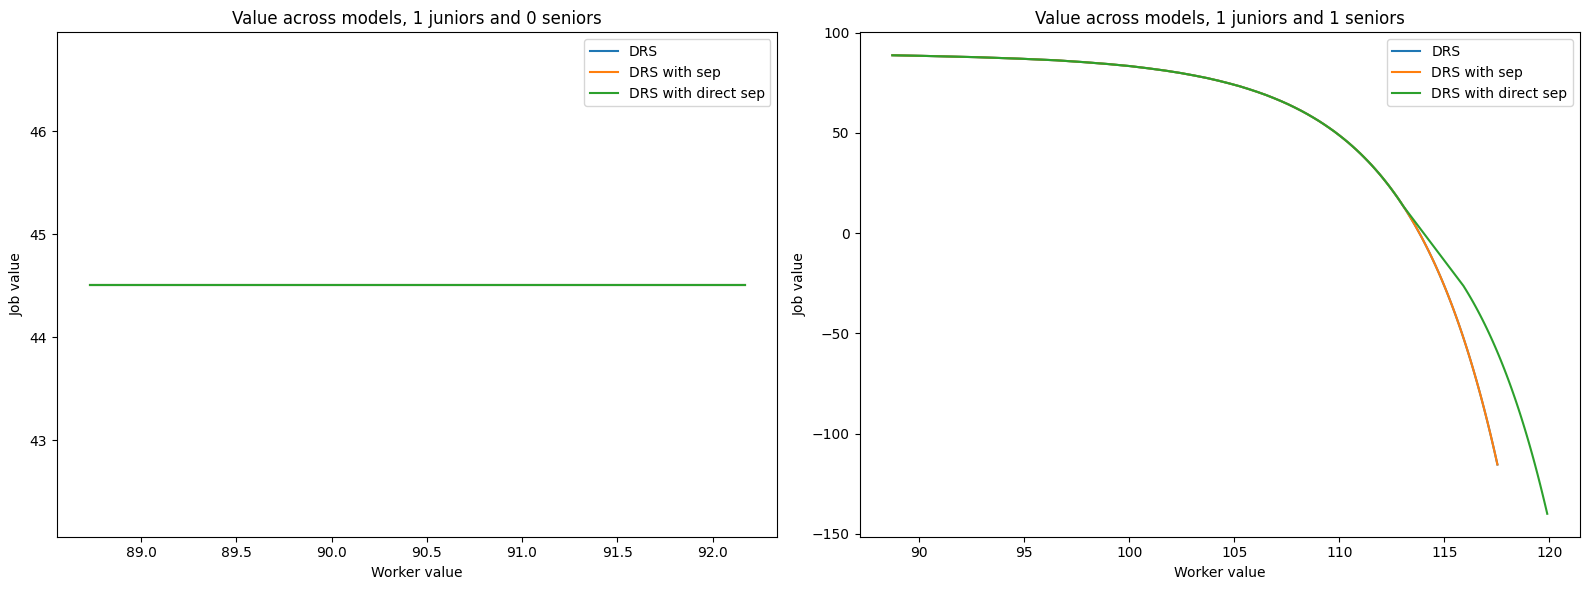

In [15]:
import matplotlib.pyplot as plt
import os

# Create a figure with a specific size
plt.figure(figsize=(16, 6))  # Width=16 inches, Height=6 inches

# First subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
jun=1
sen=0
plt.plot(mwc_W[p.z_0-1, jun, sen, :, 1], mwc_J[p.z_0-1, jun, sen, :], label='DRS')
plt.plot(mwc_s_W[p.z_0-1, jun, sen, :, 1], mwc_s_J[p.z_0-1, jun, sen, :], label='DRS with sep')
plt.plot(mwc_s_dir_W[p.z_0-1, jun, sen, :, 1], mwc_s_dir_J[p.z_0-1, jun, sen, :], label='DRS with direct sep')
plt.title(f'Value across models, {jun} juniors and {sen} seniors')
plt.xlabel('Worker value')
plt.ylabel('Job value')
plt.legend()

#plt.ylim([0, 200])

# Second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
jun=1
sen=1
plt.plot(mwc_W[p.z_0-1, jun, sen, :, 1], mwc_J[p.z_0-1, jun, sen, :], label='DRS')
plt.plot(mwc_s_W[p.z_0-1, jun, sen, :, 1], mwc_s_J[p.z_0-1, jun, sen, :], label='DRS with sep')
plt.plot(mwc_s_dir_W[p.z_0-1, jun, sen, :, 1], mwc_s_dir_J[p.z_0-1, jun, sen, :], label='DRS with direct sep')

plt.title(f'Value across models, {jun} juniors and {sen} seniors')
plt.xlabel('Worker value')
plt.ylabel('Job value')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

#plt.xlim([-10, 10])
#plt.ylim([220, 240])

# Save the plot to a file in the specified directory
save=0
if save==1:
    plt.savefig(os.path.join(output_dir,'Value CRS vs DRS.png'), bbox_inches='tight')  # Save as PNG

# Show the plot
plt.show()

In [18]:
np.abs(mwc_s_sep[:,:1,:3,:]-mwc_s_dir_sep[:,:1,:3,:]).max()

1.0

In [ ]:
x

In [ ]:
import matplotlib.pyplot as plt
import os

# Create a figure with a specific size
plt.figure(figsize=(16, 6))  # Width=16 inches, Height=6 inches

# First subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(mwc_W[p.z_0-1, 1, 0, :, 1], mwc_J[p.z_0-1, 1, 0, :], label='DRS')
plt.plot(mwc_s_W[p.z_0-1, 1, 0, :, 1], mwc_s_J[p.z_0-1, 1, 0, :], label='DRS with sep')
plt.title('Value across models, 1 junior')
plt.xlabel('Worker value')
plt.ylabel('Job value')
plt.legend()

#plt.ylim([0, 200])

# Second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(mwc_W[p.z_0-1, 1, 1, :, 1], mwc_J[p.z_0-1, 1, 1, :], label='DRS')
plt.plot(mwc_s_W[p.z_0-1, 1, 1, :, 1], mwc_s_J[p.z_0-1, 1, 1, :], label='DRS with sep')
plt.title('Value across models, 1 junior and 1 senior')
plt.xlabel('Worker value')
plt.ylabel('Job value')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

#plt.xlim([-10, 10])
#plt.ylim([220, 240])

# Save the plot to a file in the specified directory
save=0
if save==1:
    plt.savefig(os.path.join(output_dir,'Value CRS vs DRS.png'), bbox_inches='tight')  # Save as PNG

# Show the plot
plt.show()


In [ ]:
mwc_s_sep[0,1,1,:] #if the two value functions intersect, then how come the separation rate is 1?
#also thats way too many separations

In [ ]:
plt.figure(figsize=(8, 6))  # Width=16 inches, Height=12 inches

# Plot the data
plt.plot(cc_J[p.z_0-1, :], mwc_J[p.z_0-1, 0, 1, :], label='CRS vs DRS')

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))#This creates a figure and a set of subplots with a specific size. The size is specified in inches (width, height).

# Plot the original data
ax.plot(cc_W[p.z_0-1,:]+cc_J[p.z_0-1,:], mwc_W[p.z_0-1, 0, 1,:,1]+mwc_J[p.z_0-1, 0, 1, :], label='Total surplus')

# Calculate the range for the 45-degree line
x_vals = cc_W[p.z_0-1,:] + cc_J[p.z_0-1,:]
y_vals = mwc_W[p.z_0-1, 0, 1,:,1] + mwc_J[p.z_0-1, 0, 1, :]
min_val = min(min(x_vals), min(y_vals))
max_val = max(max(x_vals), max(y_vals))

# Add the 45-degree line
ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='45-degree line')

# Add titles and labels
ax.set_title('Comparing total surplus across methods')
ax.set_xlabel('Total surplus (CRS)')
ax.set_ylabel('Total surplus (DRS)')
ax.legend()

# Save the plot to a file
save=0
if save==1:
    plt.savefig(os.path.join(output_dir,'Total surplus comparison.png'), bbox_inches='tight')  # Save as PNG
#    plt.savefig(os.path.join(output_dir,'Total surplus comparison.pdf'), bbox_inches='tight')  # Save as PDF

# Show the plot
plt.show()